* This notebook is to investigate why mixing region sho up in the near field and north of the river mouth at low tides rather than high tides.

In [1]:
import numpy as np
import netCDF4 as nc
from salishsea_tools import (
    nc_tools,
    viz_tools,
    tidetools,
    stormtools
)
import datetime, os
from glob import glob
from IPython.core.display import Image,display
from nowcast import figures
import matplotlib.pyplot as plt
import matplotlib as mpl
import pytz 
mpl.rcParams.update({'font.size': 24})
mpl.rcParams["axes.formatter.useoffset"] = False
%matplotlib inline

In [2]:
sites = {
    'Sandheads': {'lat': 49.10,'lon': -123.30,'j' : 46,'i' : 53},
    'Steveston':{
        'j': 48, ##428
        'i': 52, ##292
    },
    'VENUS East':{'lat': 49.0419, 'lon': -123.3176,'depth': 170, 'j': 36, 'i': 43},    
    'VENUS Central':{ 'lat': 49.0401,'lon': -123.4261, 'depth': 300, 'j': 44, 'i': 26 },
    'Point on transect':{'j':36,'i':20},
    'mouth':{ 'j':39,'i':74},
    'near field':{'j':43,'i':64},
    'estuary':{'j':36,'i':102},
    }

In [3]:
grid6 = nc.Dataset('/ocean/jieliu/research/meopar/river-treatment/bathy_meter_SalishSea6.nc')
X = grid6.variables['nav_lon'][:, :]
Y = grid6.variables['nav_lat'][:, :]
bathy = grid6.variables['Bathymetry'][:, :]

* Load all simulation results

In [4]:
river_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014OnlyRiver/oct2014onlyriver_T.nc')
river_U = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014OnlyRiver/oct2014onlyriver_U.nc')
river_V = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014OnlyRiver/oct2014onlyriver_V.nc')
notide_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014notides/oct2014notides_T.nc')
notide_U = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014notides/oct2014notides_U.nc')
notide_V = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014notides/oct2014notides_V.nc')
nowind_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014nowind/oct2014nowind_T.nc')
nowind_U = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014nowind/oct2014nowind_U.nc')
nowind_V = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014nowind/oct2014nowind_V.nc')
nof_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014nof/oct2014nof_T.nc')
nof_U = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014nof/oct2014nof_U.nc')
nof_V = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014nof/oct2014nof_V.nc')
all_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014combineall/oct2014all_T.nc')
all_U = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014combineall/oct2014all_U.nc')
all_V = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014combineall/oct2014all_V.nc')

In [5]:
## tmask
mesh = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/oct8_101e061e05/mesh_mask.nc')
tmask = mesh.variables['tmask'][0,:,380:510,240:397]
np_mask = np.abs(1-tmask) 

# Tidal heights

In [6]:
## load t_tide
tfile = '/ocean/jieliu/research/meopar/tools/SalishSeaNowcast/\
tidal_predictions/Point Atkinson_t_tide_compare8_31-Dec-2013_02-Dec-2015.csv'
ttide, msl = stormtools.load_tidal_predictions(tfile)

In [7]:
def find_ind_tide(run_low, run_up, run_label1,run_label2):
    """To find index of ttide within a time range"""
    run_low = run_low.replace(tzinfo=pytz.utc) ## convert model datetime to tzinfo=<UTC>
    run_up = run_up.replace(tzinfo=pytz.utc) ## the time i want to label on the plot
    run_label1 = run_label1.replace(tzinfo=pytz.utc)
    run_label2 = run_label2.replace(tzinfo=pytz.utc)
    ttide_dt  = ttide.time.dt.to_pydatetime() ## convert ttide.time (pandas) to datetime
    for i in range(len(ttide_dt)):
        if ttide_dt[i]== run_low:
            low_ind = i
        if ttide_dt[i]== run_up:
            up_ind = i  
        if ttide_dt[i]== run_label1:
            lab_ind1 = i  
        if ttide_dt[i]== run_label2:
            lab_ind2 = i  
    return low_ind, up_ind, lab_ind1,lab_ind2

In [8]:
## select the time slot to make comparison
strings = {'specific time': {'t_ind_high': -4,'t_ind_low':-12,'middle of flood':-8},
              'ave':{'t_ind_high':-1,'t_ind_low':-1}}

In [28]:
def R_mix(S,t,np_mask,dep_ind,string='specific time'):
    """This function was made to calculate the R_mix ratio,
    defined by S_surf/S0, S0 is the mean salinity in the water column
    if specific time, S is the whole salinity array;
    if average over high/low tides, S is the averaged salinity array"""
    if string =='specific time':
        np_mask=np_mask +np.zeros(S[t].shape) 
        S_mask = np.ma.masked_array(S[t],mask=np_mask) ## mask sal=0 by tmask    
        S0 = np.nanmean(S_mask[0:dep_ind],axis = 0)
        r_mix = S_mask[0]/S0
    elif string =='ave':
        S_mask = np.ma.masked_array(S,mask=np_mask) ## mask sal=0 by tmask   
        S0 = np.nanmean(S_mask[0:dep_ind],axis = 0) ## S_ave['high'] is shape of (40,130,157)
        r_mix = S_mask[0]/S0
    r_mix = np.ma.masked_values(r_mix, 0)
    return r_mix

In [10]:
def average_salinity(S,t_highs,t_lows):
    """This function was amde to average the whole salinity array
    over high tides/low tides"""
    S_ave = {};
    S_ave['high'] = np.zeros((((S.shape[1],S.shape[2],S.shape[3]))))
    S_ave['low'] = S_ave['high']
    ## high/low tides
    for i, st in zip([t_highs, t_lows],['high','low']):
        S_ave[st] = S_ave[st] +S[i]
    S_ave['high'] = np.nanmean(S_ave['high'],axis = 0)
    S_ave['low'] = np.nanmean(S_ave['low'],axis = 0)
    return S_ave

In [11]:
def find_high_low_tide(start_day, end_day):
    """This function was made to find time of 
    the low, high tide of a day, unit is in utc, 
    return ts: time index of the time range we want.
    t_highs: time index of daily high tides during the time period,
    t_lows: time index of daily low tides during the time period"""
    ## zoom in the days we want
    ts = []; t_highs = []; t_lows = []
    for i in np.arange(len(ttide.time)):
        if (start_day.year == ttide.time[i].year) & (start_day.month == ttide.time[i].month) &\
    (start_day.day == ttide.time[i].day) & (start_day.hour == ttide.time[i].hour):
            ts.append(i)
        if (end_day.year == ttide.time[i].year) & (end_day.month == ttide.time[i].month) &\
    (end_day.day == ttide.time[i].day) & (end_day.hour == ttide.time[i].hour):
            ts.append(i)
    t_ind = 0; ## time index of high and low tide, in order to loop
    ## get all the time for high and low tide
    for t in np.arange(ts[0],ts[1]+1,24):
        high = np.nanmax([ttide.pred_all[t:t+24]])
        low = np.nanmin([ttide.pred_all[t:t+24]])
        h_t = t_ind+np.argmax([ttide.pred_all[t:t+24]])
        l_t = t_ind+np.argmin([ttide.pred_all[t:t+24]])
        t_highs.append(h_t); t_lows.append(l_t)
        t_ind = t_ind +24
    return t_highs, t_lows

In [26]:
def plot_salinity_estuary(grid_T,start_day, end_day,dep_ind,np_mask,grid_T2 = None,title = ' no wind',\
                          string ='specific time',smin = 0, smax = 36,rmin = 0, rmax = 1.0):
    """This function was made to plot salinity along the transect in 
    different forcing cases"""
    S = grid_T.variables['vosaline']
    lon = grid_T.variables['nav_lon']
    dep = grid_T.variables['deptht']
    cmap = plt.get_cmap('jet')

    if string  =='specific time':
        f, ((ax1, ax2, ax5), (ax3, ax4,ax6)) = plt.subplots(2, 3, sharex='col',sharey='row',figsize = (14,8))
        f.subplots_adjust(hspace=0)
        for ax, st in zip([ax1,ax2,ax5],['t_ind_low','middle of flood','t_ind_high']):
            r_mix = R_mix(S,strings[string][st],np_mask,dep_ind, string = string)
            ax.plot(lon[36,4:123],r_mix[36,4:123],'r-*')
            ax.set_ylim([rmin,rmax])
            ax.annotate('Estuary',(-123.05,0))
            ax.annotate('Mouth',(-123.16,0))
            ax.annotate('Near field',(-123.25,0))
            ax.annotate('Far field',(-123.4,0))
            ax.set_ylabel('Rmix')
            ax.set_title(st+' tide of'+title)
        for ax, st in zip([ax3,ax4,ax6],['t_ind_low','middle of flood','t_ind_high']):
            np_mask=np_mask +np.zeros(S[strings[string][st]].shape) 
            S_else = np.ma.masked_array(S[strings[string][st]],mask=np_mask) ## mask sal=0 by tmask
            mesh = ax.contourf(lon[36,4:123], dep[:], S_else[:,36,4:123],np.arange(smin,smax+3,3),cmap = cmap)     
            cbar=f.colorbar(mesh,ax = ax,orientation ='horizontal')
            cbar.set_label('Practical Salinity')
            ax.set_xlabel('Lon')
            ax.set_ylabel('Depth [m]')
            ax.set_xlim([lon[36,4],lon[36,123]])
            ax.set_ylim([dep[dep_ind],0])
    elif string =='ave':
        t_highs, t_lows = find_high_low_tide(start_day,end_day) ## range of days
        S_ave = average_salinity(S,t_highs,t_lows) ## averaged salinity 
        f, ((ax1, ax2), (ax3, ax4))= plt.subplots(2, 2, sharex='col',sharey='row',figsize = (14,8))
        f.subplots_adjust(hspace=0)
        for ax, st in zip ([ax1,ax2],['low','high']):
            r_mix = R_mix(S_ave[st],strings[string]['t_ind_low'],np_mask,dep_ind, string = string)
            ax.plot(lon[36,4:123],r_mix[36,4:123],'r-*')
            ax.set_ylim([rmin,rmax])
            ax.annotate('Estuary',(-123.05,0))
            ax.annotate('Mouth',(-123.16,0))
            ax.annotate('Near field',(-123.25,0))
            ax.annotate('Far field',(-123.4,0))
            ax.set_ylabel('Rmix')
            ax.set_title('averaged '+st+' tide of'+title)
        for ax, st in zip([ax3,ax4],['low','high']):
            np_mask=np_mask +np.zeros(S_ave[st].shape) 
            S_else = np.ma.masked_array(S_ave[st],mask=np_mask) ## mask sal=0 by tmask
            mesh = ax.contourf(lon[36,4:123], dep[:], S_else[:,36,4:123],np.arange(smin,smax+3,3),cmap = cmap)     
            cbar=f.colorbar(mesh,ax = ax,orientation ='horizontal')
            cbar.set_label('Practical Salinity')
            ax.set_xlabel('Lon')
            ax.set_ylabel('Depth [m]')
            ax.set_xlim([lon[36,4],lon[36,123]])
            ax.set_ylim([dep[dep_ind],0])

    return f

In [20]:
def plot_spatial_Rmix(grid_T,start_day,end_day,dep_ind,np_mask,string = 'specific time',\
                      title = ' no wind',smin = 0,smax = 1.1,inter = 0.1):
    """This function was made to plot the spatial 
    map of Rmix contour"""
    S = grid_T.variables['vosaline']
    lon = grid_T.variables['nav_lon']
    lat = grid_T.variables['nav_lat']
    cs = np.arange(smin,smax,inter)
    if string =='specific time':
        tides = ['Low tide of', 'Middle of flood tide of ','High tide of']
        strs = ['t_ind_low','middle of flood','t_ind_high']
        fig, axs = plt.subplots(1,3,figsize = (14,6))
        for st,ax,ti in zip(strs,axs,tides):
            r_mix = R_mix(S,strings[string][st],np_mask,dep_ind,string = string)
            mesh = ax.contourf(lon[:],lat[:],r_mix[:],cs,cmap = 'jet')
            cbar=fig.colorbar(mesh,ax = ax,orientation ='horizontal')
            cbar.set_label('Rmix')
    elif string =='ave':
        strs = ['high','low']
        t_highs, t_lows = find_high_low_tide(start_day,end_day) ## range of days
        S_ave = average_salinity(S,t_highs,t_lows) ## averaged salinity 
        tides = ['Low tide of','High tide of']
        fig, axs = plt.subplots(1,2,figsize = (14,6))
        for st,ax,ti in zip(strs,axs, tides):
            r_mix = R_mix(S_ave[st],strings[string]['t_ind_high'],np_mask,dep_ind, string = string)
            mesh = ax.contourf(lon[:],lat[:],r_mix[:],cs,cmap = 'jet')
            cbar=fig.colorbar(mesh,ax = ax,orientation ='horizontal')
            cbar.set_label('Rmix')
    for ax, ti in zip(axs, tides):
        ax.plot(lon[36,4:123],lat[36,4:123],'k-') ## transect
        viz_tools.plot_land_mask(ax,grid6,coords='map',color='burlywood')
        viz_tools.plot_coastline(ax, grid6, coords = 'map')
        ax.set_xlim([-123.75,-122.8])
        ax.set_ylim([48.85,49.4])
        ax.set_title(ti+title)
    return fig

In [15]:
def plot_spatial_circulation(grid_T,grid_U,grid_V,dep_ind,string,str2,smin = 0,smax = 36,st=3):
    """This function was made to plot the circulation pattern of each case of 
    specific time"""
    fig, axs= plt.subplots(1,3,figsize=(14,6))
    dep = grid_T.variables['deptht']
    lon = grid_T.variables['nav_lon']
    lat = grid_T.variables['nav_lat']
    U = grid_U.variables['vozocrtx']
    V = grid_V.variables['vomecrty']
    for t, ax in zip (['t_ind_low','middle of flood','t_ind_high'], axs):
        UU,VV = viz_tools.unstagger(U[strings[string][t],dep_ind,:,:],V[strings[string][t],dep_ind,:,:])
        #rotate
        theta = np.pi*29/180
        UU = UU*np.cos(theta) - VV*np.sin(theta)
        VV = UU*np.sin(theta) +VV*np.cos(theta)
        S = grid_T.variables['vosaline'][strings[string][t],dep_ind,:,:]
        mesh=ax.pcolormesh(lon,lat,S[:],cmap='spectral')
        cbar = plt.colorbar(mesh, ax=ax)
        cbar.set_label('Practical Salinity')
        mesh.set_clim(vmin=smin, vmax=smax)
        #quivers
        lonn = grid_T.variables['nav_lon'][:-1,:-1]
        latt = grid_T.variables['nav_lat'][:-1,:-1]
        quiver = ax.quiver(lonn[::st,::st], latt[::st,::st], UU[::st,::st], VV[::st,::st],
                pivot='mid', width=0.003,scale=5, color='black',headwidth=2,headlength=2)
        ax.quiverkey(quiver,-123.1,49.2, 0.5, '0.5 m/s',coordinates='data', color='black', labelcolor='black')
        #land
        viz_tools.plot_land_mask(ax,grid6,coords='map',color='burlywood')
        viz_tools.plot_coastline(ax, grid6, coords = 'map')
        viz_tools.plot_coastline(ax, grid6, coords = 'map', isobath = 5,color = 'DarkViolet')
        ax.set_xlim([-123.75,-122.8])
        ax.set_ylim([48.85,49.4])
        ax.set_title(string+ str2)
    return fig

In [17]:
## define dates
sd = datetime.datetime(2014,10,1,0,30,tzinfo=pytz.utc)
ed = datetime.datetime(2014,10,31,23,30,tzinfo=pytz.utc)

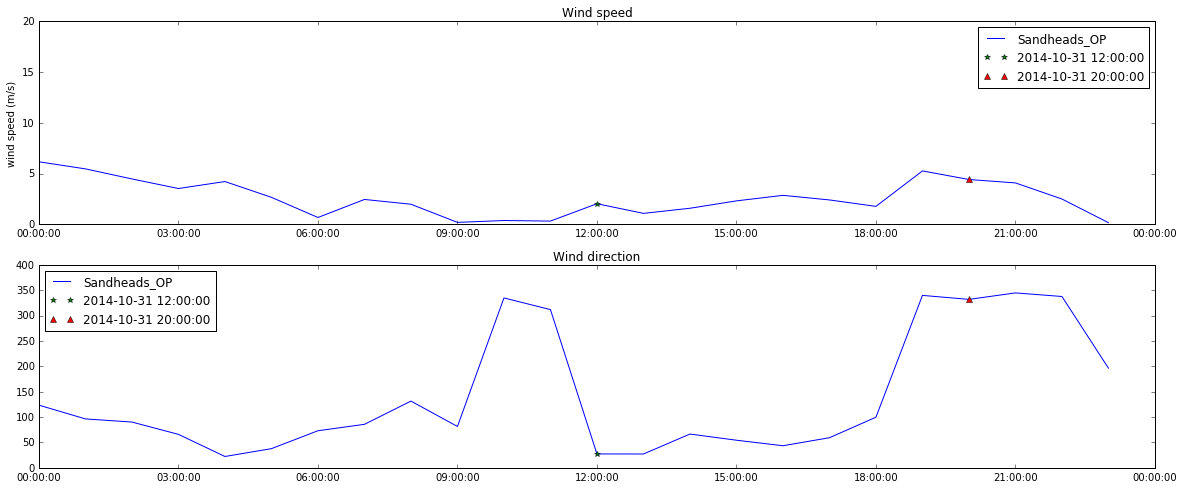

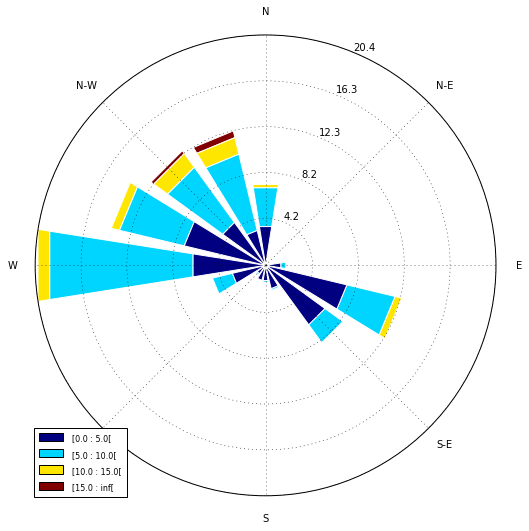

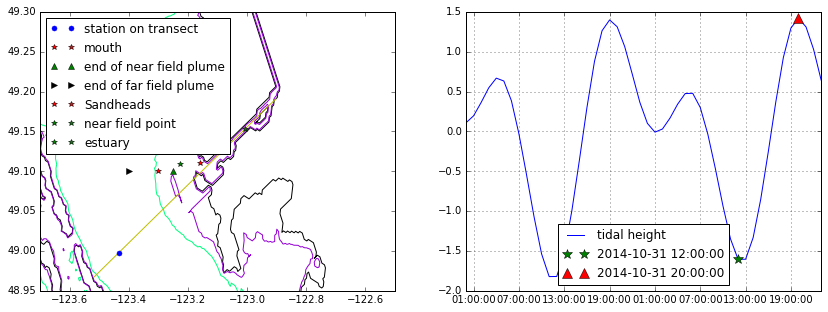

In [15]:
fig, axs = plt.subplots(1,2,figsize = (14,5))
ax = axs[0]
viz_tools.plot_coastline(ax, grid6, coords = 'map')
viz_tools.plot_coastline(ax, grid6, coords = 'map', isobath = 5,color = 'DarkViolet')
viz_tools.plot_coastline(ax, grid6, coords = 'map', isobath = 50,color = 'springgreen')
lon = all_T.variables['nav_lon']
lat = all_T.variables['nav_lat']
ax.plot(lon[36,4:123],lat[36,4:123],'y-') ## transect
ax.plot(lon[36,20],lat[36,20],'b.',markersize = 10,label ='station on transect')
ax.plot(-123.16, 49.11,'r*',label = 'mouth') ## (39,74)
ax.plot(-123.25, 49.1,'g^',label = 'end of near field plume') ## (43,59)
ax.plot(-123.4, 49.1,'k>',label = 'end of far field plume') ## (33,38)
ax.plot(-123.3,49.1,'r*',label = 'Sandheads')
ax.plot(lon[43,64],lat[43,64],'g*',label = 'near field point') ## (43,64)
ax.plot(lon[36,102],lat[36,102],'g*',label = 'estuary') ## (36,102)
ax.set_xlim([-123.7,-122.5])
ax.set_ylim([48.95,49.3])
ax.legend(loc  = 'best')
ax = axs[1]
run_low = datetime.datetime(2014,10,30)
run_up = datetime.datetime(2014,11,1)
run_label1 = datetime.datetime(2014,10,31,12)
run_label2 = datetime.datetime(2014,10,31,20)
low_ind,up_ind,lab_ind1,lab_ind2 = find_ind_tide(run_low,run_up,run_label1,run_label2)
ax.plot(ttide.time[low_ind:up_ind], ttide.pred_all[low_ind:up_ind],label = 'tidal height')
ax.plot(ttide.time[lab_ind1],ttide.pred_all[lab_ind1],'g*',markersize = 10,label = run_label1)
ax.plot(ttide.time[lab_ind2],ttide.pred_all[lab_ind2],'r^',markersize = 10,label = run_label2)
ax.legend(loc = 'best')
ax.grid('on')
X =Image(filename='/ocean/jieliu/research/meopar/surface current/wind_31oct14.png')
Y =Image(filename='/ocean/jieliu/research/meopar/surface current/windrose.png')
display(X,Y)

# R_mix plot

# No wind case

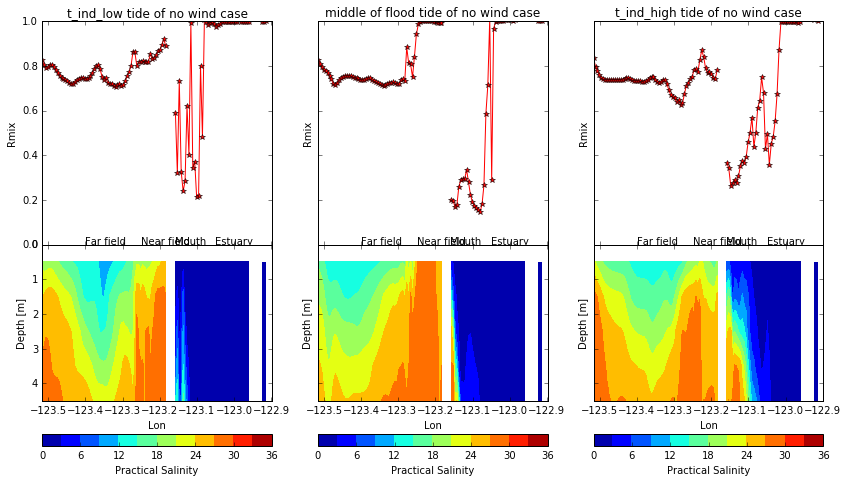

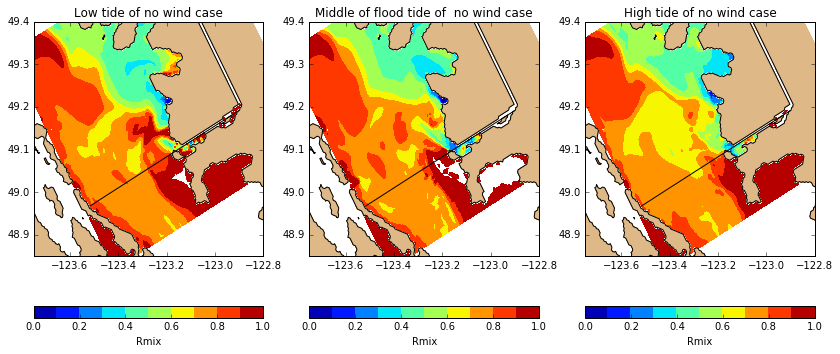

In [21]:
fig= plot_salinity_estuary(nowind_T,sd,ed,4,np_mask,title = ' no wind case')
fig = plot_spatial_Rmix(nowind_T,sd,ed,4, np_mask,title = ' no wind case')

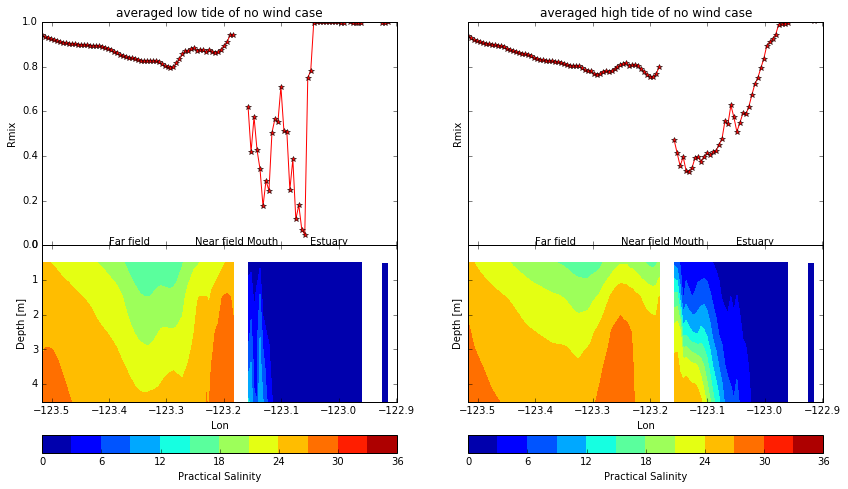

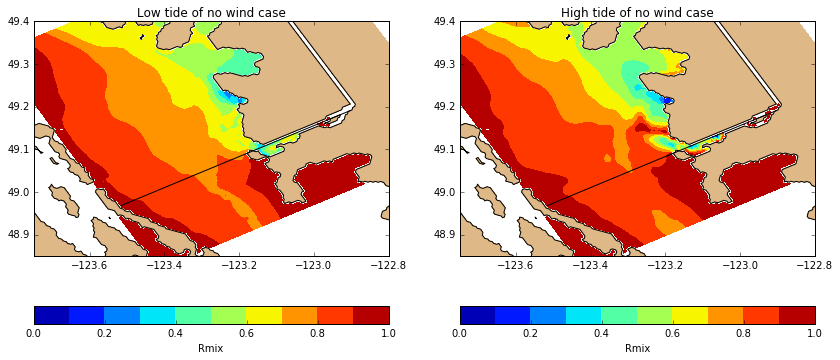

In [29]:
fig= plot_salinity_estuary(nowind_T,sd,ed,4,np_mask,title = ' no wind case',string = 'ave')
fig = plot_spatial_Rmix(nowind_T,sd,ed,4, np_mask,title = ' no wind case',string = 'ave')

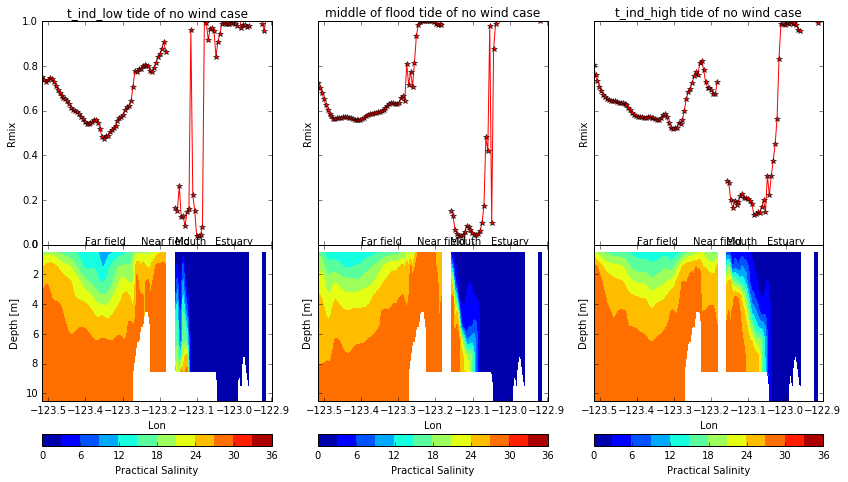

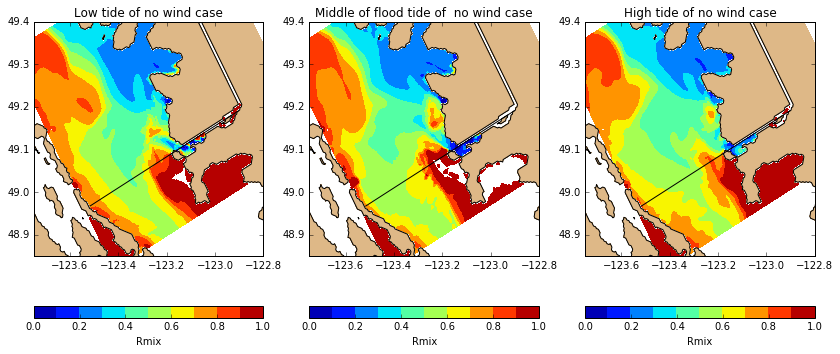

In [23]:
fig = plot_salinity_estuary(nowind_T,sd,ed,10,np_mask,title = ' no wind case')
fig = plot_spatial_Rmix(nowind_T,sd,ed,10, np_mask,title = ' no wind case')

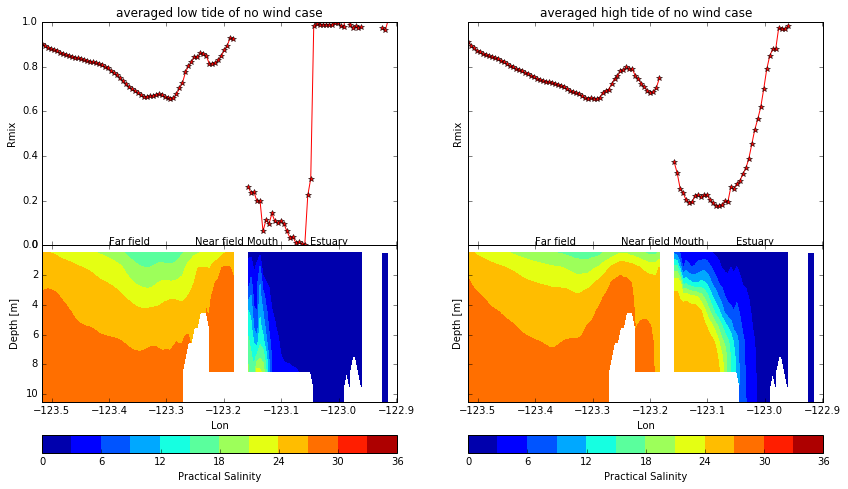

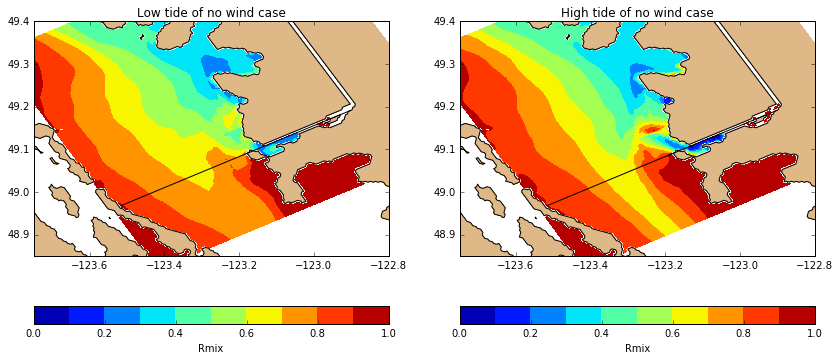

In [30]:
fig= plot_salinity_estuary(nowind_T,sd,ed,10,np_mask,title = ' no wind case',string = 'ave')
fig = plot_spatial_Rmix(nowind_T,sd,ed,10, np_mask,title = ' no wind case',string = 'ave')

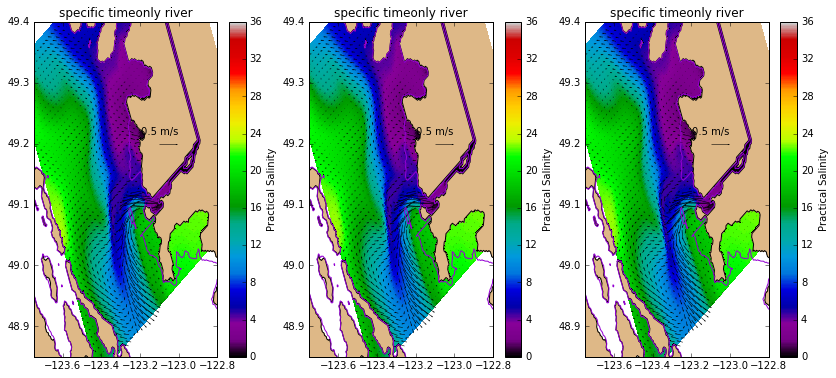

In [16]:
fig = plot_spatial_circulation(river_T,river_U,river_V,0,'specific time','only river')

# Combine all case